# Task07 【代码实战】LIME、shap

## 1 基于Shapley值的可解释性分析

- 理论来源：博弈论中的shapley值
- 概念理解：Shapley值反映了在多人联盟博弈时，某人加入组织，对最终博弈决策带来的边际贡献；在机器学习中某特征引入时，对模型预测结果带来的边际影响（特征重要度）

In [1]:
import torch
import torchvision
from torchvision import datasets, transforms, models
from torch import nn, optim
from torch.nn import functional as F
import os

import numpy as np
import json
from PIL import Image

In [2]:
# 使用torch-gpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

## 2 shap代码实战

In [3]:
import shap

### 2.1 使用Pytorch对MNIST分类可解释性分析¶

用Pytorch构建简单的卷积神经网络，在MNIST手写数字数据集上，使用shap的Deep Explainer进行可解释性分析，并可视化每一张图像的每一个像素，对模型预测为每一个类别的影响。

In [4]:
# 构建卷积神经网络
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout(),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(-1, 320)
        x = self.fc_layers(x)
        return x

In [5]:
# 初始化模型
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [6]:
# 加载MNIST数据集
train_dataset = datasets.MNIST('mnist_data', 
                               train=True, 
                               download=True,
                               transform=transforms.Compose([transforms.ToTensor()]))

test_dataset = datasets.MNIST('mnist_data', 
                               train=False, 
                               download=True,
                               transform=transforms.Compose([transforms.ToTensor()]))

In [7]:
# 设置dataloader
batch_size = 256
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size, 
    shuffle=True)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size, 
    shuffle=True)

In [8]:
def train(model, device, train_loader, optimizer, epoch):
    # 训练一个 epoch
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output.log(), target).to(device)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    # 测试一个 epoch
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output.log(), target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [9]:
num_epochs = 5

for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.297472
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.202407
Train Epoch: 1 [51200/60000 (85%)]	Loss: 1.399053

Test set: Average loss: 0.0050, Accuracy: 7855/10000 (79%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.234514
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.933571
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.774069

Test set: Average loss: 0.0025, Accuracy: 8880/10000 (89%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.748982
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.621569
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.535523

Test set: Average loss: 0.0017, Accuracy: 9151/10000 (92%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.569322
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.596375
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.552551

Test set: Average loss: 0.0014, Accuracy: 9330/10000 (93%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.447947
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.550949
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.531695

Test set: Average loss: 0.0012

#### 使用shap的Deep Explainer进行可视化

In [10]:
images, labels = next(iter(test_loader))

In [11]:
# 背景图像样本
background = images[:250]
background.shape

torch.Size([250, 1, 28, 28])

In [12]:
# 测试图像样本
test_images = images[250:254]
test_images.shape

torch.Size([4, 1, 28, 28])

In [13]:
# 初始化Deep Explainer
background = background.to(device)

e = shap.DeepExplainer(model, background)

In [14]:
# 计算每个类别、每张测试图像、每个像素，对应的 shap 值
shap_values = e.shap_values(test_images)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [15]:
# shap 值
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]

# 测试图像
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

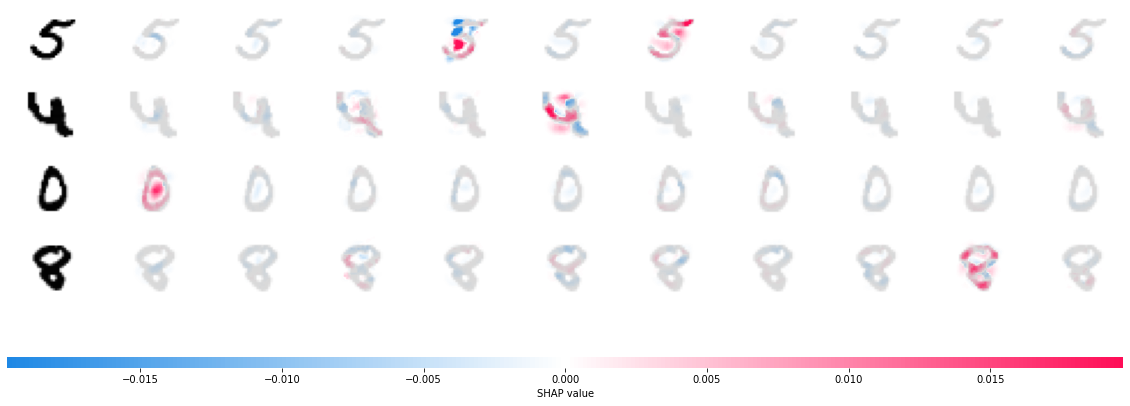

In [16]:
shap.image_plot(shap_numpy, -test_numpy)

- 红色代表 shap 正值：对模型预测为该类别有正向作用
- 蓝色代表 shap 负值：对模型预测为该类别有负向作用

### 2.2 使用Pytorch对预训练ImageNet图像分类可解释性分析

In [17]:
# 载入ImageNet预训练图像分类模型
model = torchvision.models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT, progress=False).eval().to(device)

In [18]:
with open('./data/imagenet_class_index.json') as file:
    class_names = [v[1] for v in json.load(file).values()]

In [19]:
# 测试图片
img_path = 'test_img/cat_dog.jpg'

img_pil = Image.open(img_path)
X = torch.Tensor(np.array(img_pil)).unsqueeze(0)

In [20]:
# 预处理
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def nhwc_to_nchw(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[1] == 3 else x.permute(0, 3, 1, 2)
    elif x.dim() == 3:
        x = x if x.shape[0] == 3 else x.permute(2, 0, 1)
    return x

def nchw_to_nhwc(x: torch.Tensor) -> torch.Tensor:
    if x.dim() == 4:
        x = x if x.shape[3] == 3 else x.permute(0, 2, 3, 1)
    elif x.dim() == 3:
        x = x if x.shape[2] == 3 else x.permute(1, 2, 0)
    return x 
        

transform= [
    transforms.Lambda(nhwc_to_nchw),
    transforms.Resize(224),
    transforms.Lambda(lambda x: x*(1/255)),
    transforms.Normalize(mean=mean, std=std),
    transforms.Lambda(nchw_to_nhwc),
]

inv_transform= [
    transforms.Lambda(nhwc_to_nchw),
    transforms.Normalize(
        mean = (-1 * np.array(mean) / np.array(std)).tolist(),
        std = (1 / np.array(std)).tolist()
    ),
    transforms.Lambda(nchw_to_nhwc),
]

transform = torchvision.transforms.Compose(transform)
inv_transform = torchvision.transforms.Compose(inv_transform)

In [21]:
# 构建模型预测函数
def predict(img: np.ndarray) -> torch.Tensor:
    img = nhwc_to_nchw(torch.Tensor(img)).to(device)
    output = model(img)
    return output

def predict(img):
    img = nhwc_to_nchw(torch.Tensor(img)).to(device)
    output = model(img)
    return output

In [22]:
Xtr = transform(X)
out = predict(Xtr[0:1])

In [23]:
classes = torch.argmax(out, axis=1).detach().cpu().numpy()
print(f'Classes: {classes}: {np.array(class_names)[classes]}')

Classes: [239]: ['Bernese_mountain_dog']


In [24]:
# 构造输入图像
input_img = Xtr[0].unsqueeze(0)

In [25]:
batch_size = 50

n_evals = 5000 # 迭代次数越大，显著性分析粒度越精细，计算消耗时间越长

# 定义 mask，遮盖输入图像上的局部区域
masker_blur = shap.maskers.Image("blur(64, 64)", Xtr[0].shape)

# 创建可解释分析算法
explainer = shap.Explainer(predict, masker_blur, output_names=class_names)

#### 指定单个预测类别

In [26]:
# 281：虎斑猫 tabby
shap_values = explainer(input_img, max_evals=n_evals, batch_size=batch_size, outputs=[281])

  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:13, 13.87s/it]                                                                                                                                                                  


In [27]:
# 整理张量维度
shap_values.data = inv_transform(shap_values.data).cpu().numpy()[0] # 原图
shap_values.values = [val for val in np.moveaxis(shap_values.values[0],-1, 0)] # shap值热力图

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


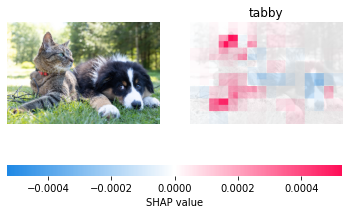

In [28]:
# 可视化
shap.image_plot(shap_values=shap_values.values,
                pixel_values=shap_values.data,
                labels=shap_values.output_names)

#### 指定多个预测类别

  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:12, 12.34s/it]                                                                                                                                                                  
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


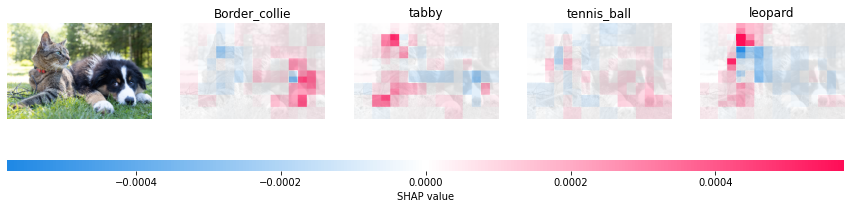

In [29]:
# 232 边牧犬 border collie
# 281：虎斑猫 tabby
# 852 网球 tennis ball
# 288 豹子 leopard
shap_values = explainer(input_img, max_evals=n_evals, batch_size=batch_size, outputs=[232, 281, 852, 288])

# 整理张量维度
shap_values.data = inv_transform(shap_values.data).cpu().numpy()[0] # 原图
shap_values.values = [val for val in np.moveaxis(shap_values.values[0],-1, 0)] # shap值热力图

# 可视化
shap.image_plot(shap_values=shap_values.values,
                pixel_values=shap_values.data,
                labels=shap_values.output_names)

#### 前k个预测类别

  0%|          | 0/4998 [00:00<?, ?it/s]

Partition explainer: 2it [00:12, 12.28s/it]                                                                                                                                                                  
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


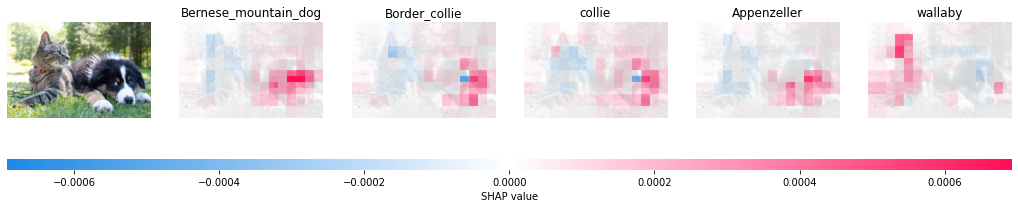

In [30]:
topk = 5

shap_values = explainer(input_img, max_evals=n_evals, batch_size=batch_size, outputs=shap.Explanation.argsort.flip[:topk])

# 整理张量维度
shap_values.data = inv_transform(shap_values.data).cpu().numpy()[0] # 原图
shap_values.values = [val for val in np.moveaxis(shap_values.values[0],-1, 0)] # 各个类别的shap值热力图

# 可视化
shap.image_plot(shap_values=shap_values.values,
                pixel_values=shap_values.data,
                labels=shap_values.output_names
                )

## 3 LIME代码实战

### 3.1 对葡萄酒数据集二分类并进行LIME可解释性分析

#### 使用随机森林模型对葡萄酒数据集二分类

In [31]:
import numpy as np
import pandas as pd

import lime
from lime import lime_tabular

In [32]:
# 加载数据集
df = pd.read_csv('./data/wine.csv')

In [33]:
df.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol quality  
0      8.8     bad  
1      9.5     bad  
2     10.1     bad  
3      9.9     bad  
4      9.9     bad

In [34]:
from sklearn.model_selection import train_test_split

X = df.drop('quality', axis=1)
y = df['quality']

# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
from sklearn.ensemble import RandomForestClassifier

# 使用随机森林模型训练
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [36]:
score = model.score(X_test, y_test)
score

0.8887755102040816

#### LIME可解释性分析

In [37]:
# 初始化LIME可解释性分析算法
explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train), # 训练集特征，必须是 numpy 的 Array
    feature_names=X_train.columns, # 特征列名
    class_names=['bad', 'good'], # 预测类别名称
    mode='classification' # 分类模式
)

In [38]:
# 从测试集中选取一个样本，输入训练好的模型中预测，查看预测结果
idx = 3

data_test = np.array(X_test.iloc[idx]).reshape(1, -1)
prediction = model.predict(data_test)[0]
y_true = np.array(y_test)[idx]
print('测试集中的 {} 号样本, 模型预测为 {}, 真实类别为 {}'.format(idx, prediction, y_true))

测试集中的 3 号样本, 模型预测为 bad, 真实类别为 bad


In [39]:
# 可解释性分析
exp = explainer.explain_instance(
    data_row=X_test.iloc[idx], 
    predict_fn=model.predict_proba
)

In [40]:
exp.show_in_notebook(show_table=True)

### 3.2 对ImageNet预训练图像分类并进行LIME可解释性分析

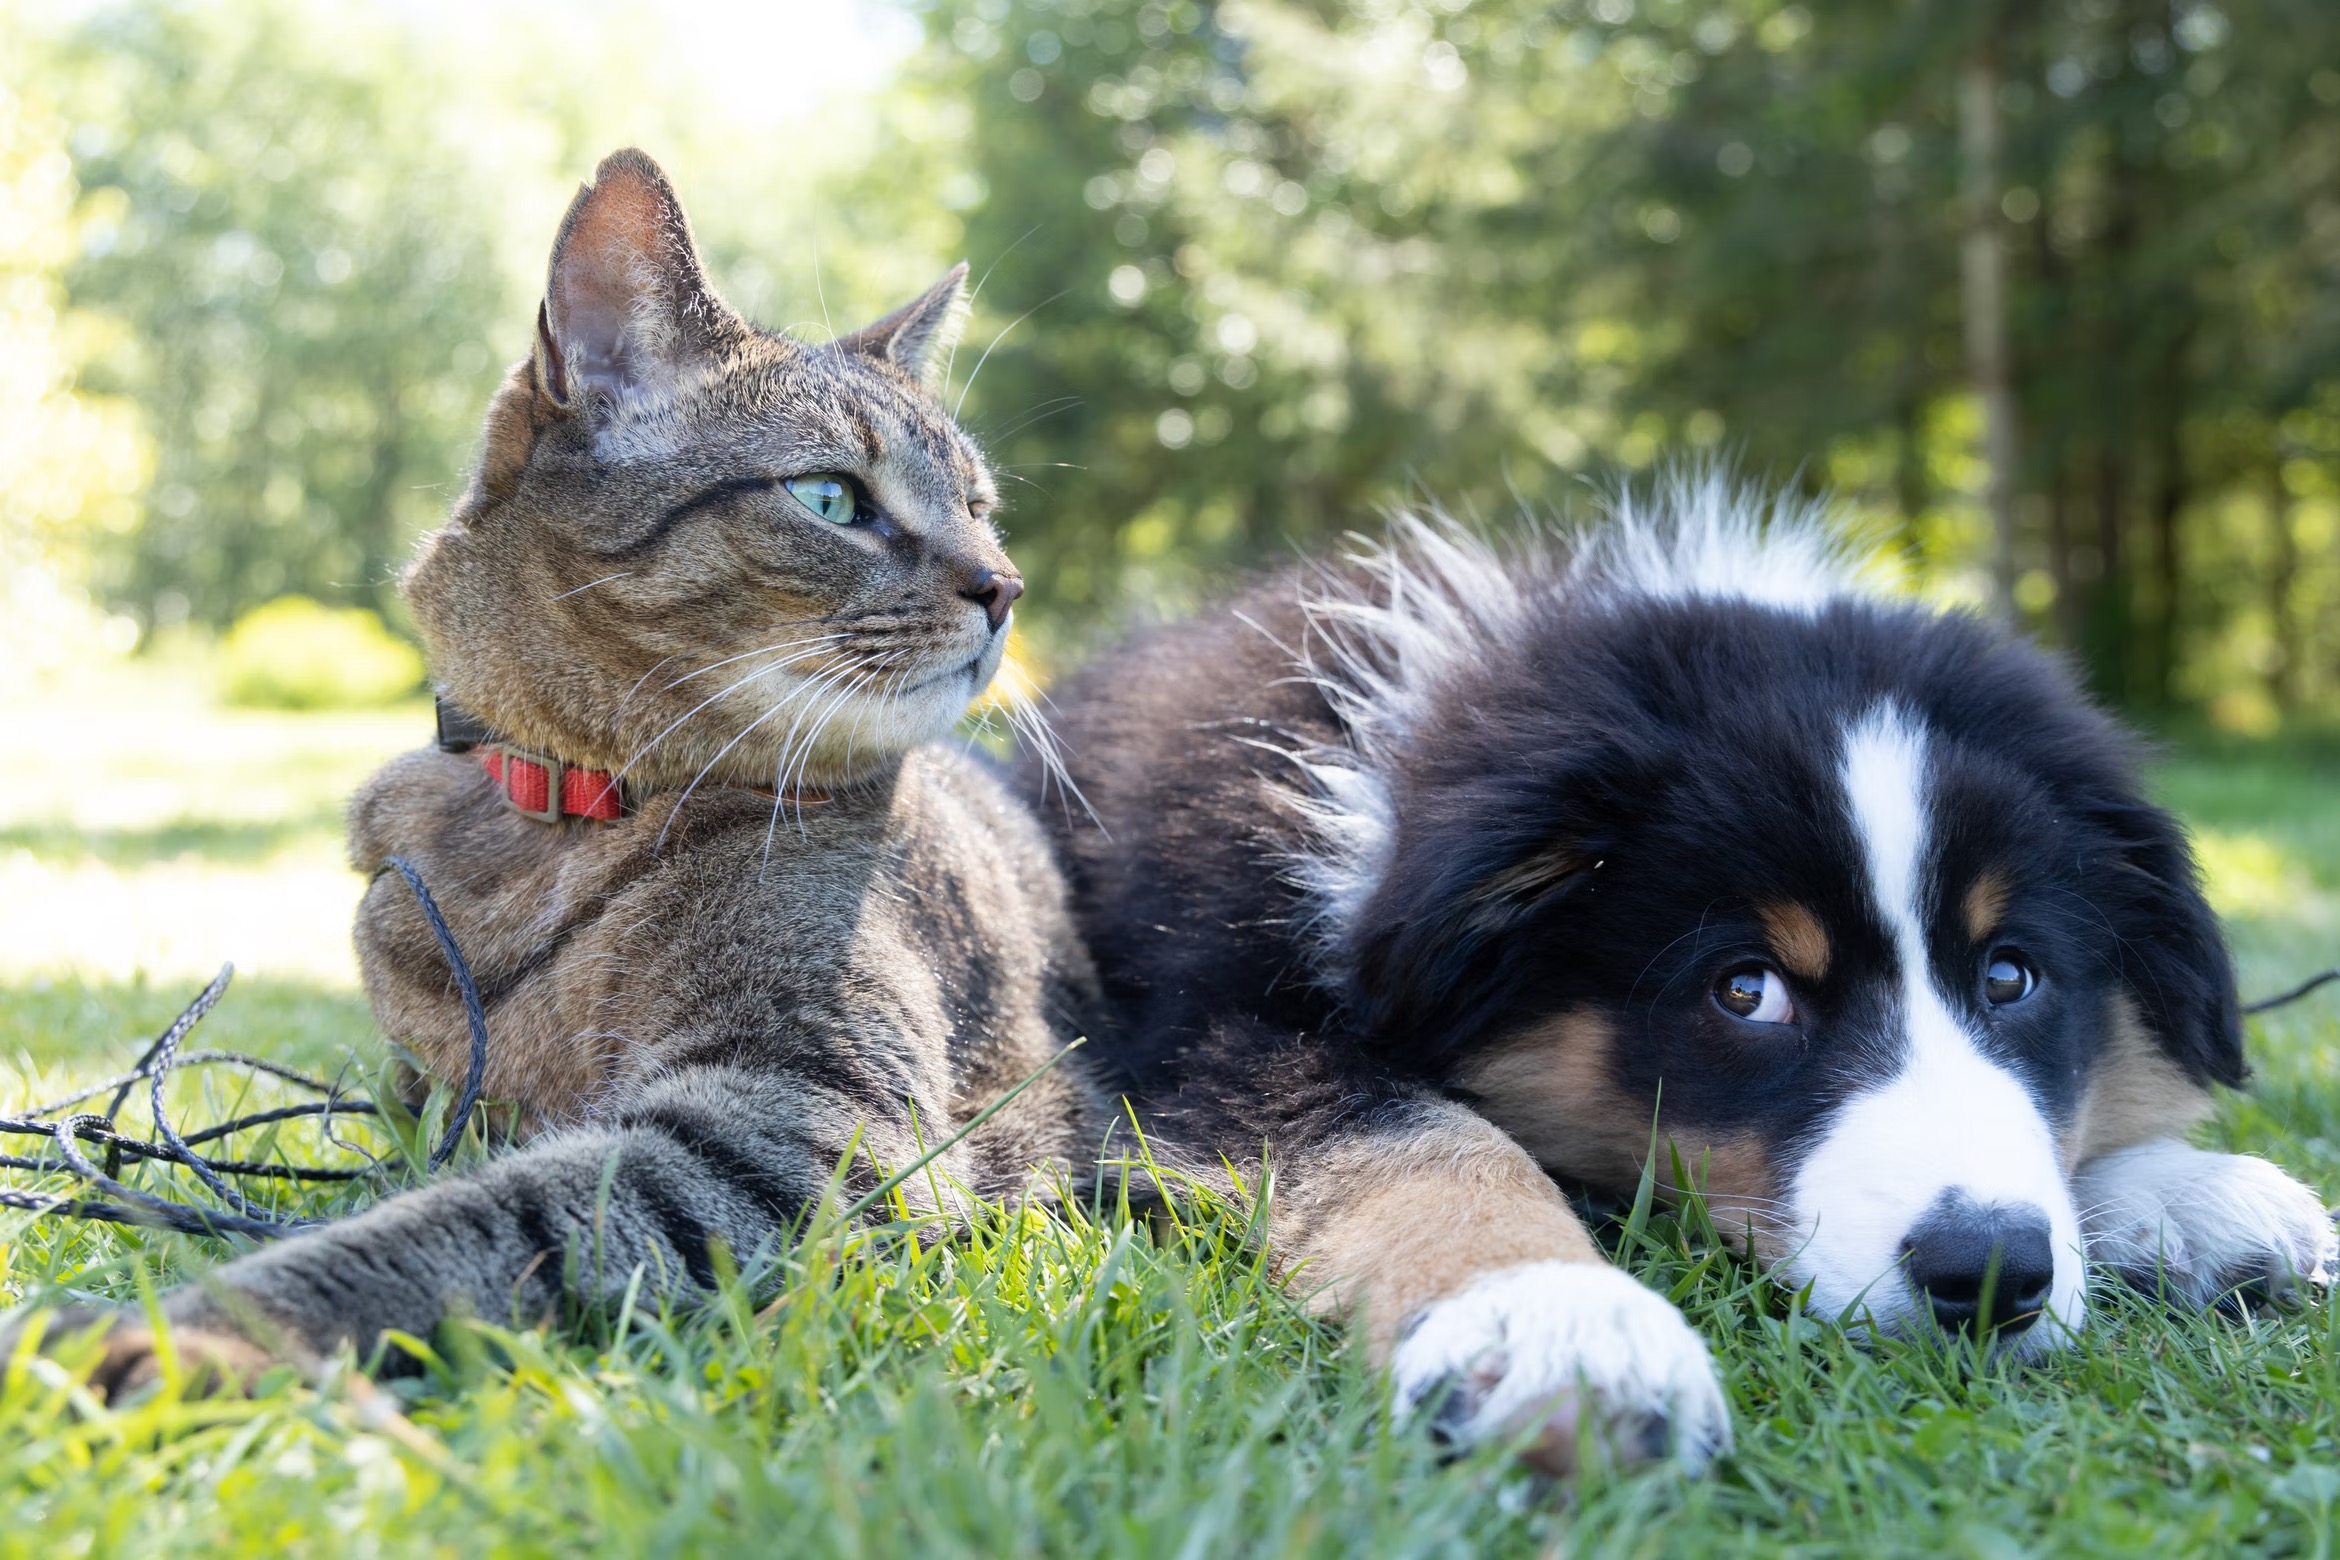

In [41]:
img_path = './test_img/cat_dog.jpg'

img_pil = Image.open(img_path)
img_pil

In [42]:
# 加载模型
model = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT).eval().to(device)

In [43]:
# 载入ImageNet-1000类别
idx2label, cls2label, cls2idx = [], {}, {}
with open('./data/imagenet_class_index.json', 'r') as read_file:
    class_idx = json.load(read_file)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    cls2label = {class_idx[str(k)][0]: class_idx[str(k)][1] for k in range(len(class_idx))}
    cls2idx = {class_idx[str(k)][0]: k for k in range(len(class_idx))}    

In [44]:
# 预处理
trans_norm = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])

trans_A = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    trans_norm
    ])

trans_B = transforms.Compose([
        transforms.ToTensor(),
        trans_norm
    ])

trans_C = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224)
])

In [45]:
# 进行图像分类
input_tensor = trans_A(img_pil).unsqueeze(0).to(device)
pred_logits = model(input_tensor)
pred_softmax = F.softmax(pred_logits, dim=1)
top_n = pred_softmax.topk(5)

In [46]:
# 定义分类预测函数
def batch_predict(images):
    batch = torch.stack(tuple(trans_B(i) for i in images), dim=0)
    batch = batch.to(device)
    
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [47]:
test_pred = batch_predict([trans_C(img_pil)])
test_pred.squeeze().argmax()

231

#### LIME可解释性分析

In [48]:
from lime import lime_image

In [49]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(np.array(trans_C(img_pil)), 
                                         batch_predict, # 分类预测函数
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=8000) # LIME生成的邻域图像个数

  0%|          | 0/8000 [00:00<?, ?it/s]

In [50]:
explanation.top_labels[0]

231

In [51]:
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

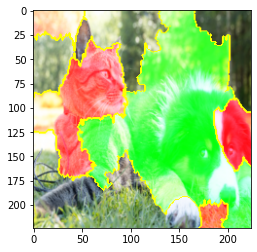

In [52]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=20, hide_rest=False)
img_boundry = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry)
plt.show()

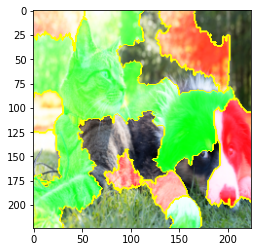

In [53]:
temp, mask = explanation.get_image_and_mask(281, positive_only=False, num_features=20, hide_rest=False)
img_boundry = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry)
plt.show()

**注**：绿色表示该区域对当前类别影响为正，红色表示该区域对当前类别影响为负

## 4 本章总结

本次任务，主要介绍了shap和lime工具包的使用，包括：

1. 介绍基于Shapley值的可解释性分析的理论
2. 使用shap工具包，对MNIST数据集、预训练ImageNet模型（MobileNet_V2）进行分类和shap可解释性分析
3. 使用lime工具包，对葡萄酒数据集、预训练ImageNet模型（Inception_V3）进行二分类和LIME可解释性分析